In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as math
from typing import Dict
from typing import Tuple

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()
data = boston.data
target = boston.target
features = boston.feature_names
len(data)

506

In [3]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [78]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

## Regression

In [5]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

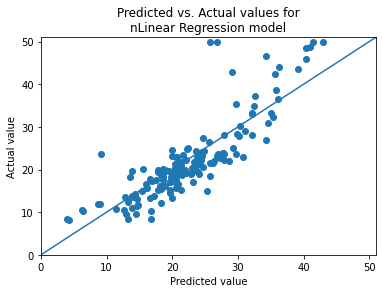

In [6]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\nnLinear Regression model")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51])

## Testing changing features

Text(0.5, 1.0, 'Relationship between most\nimportant feature and target')

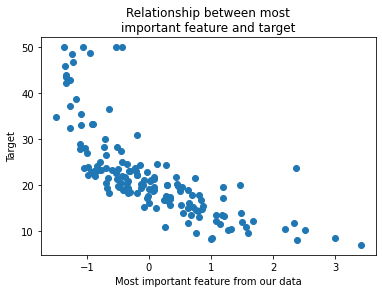

In [84]:
plt.scatter(X_test[:, 12], y_test)
plt.xlabel("Most important feature from our data")
plt.ylabel("Target")
plt.title("Relationship between most\nimportant feature and target")

## Model error

In [8]:
def mae(preds: np.ndarray, actuals: np.ndarray):
    '''
    Compute mean absolute error.
    '''
    return np.mean(np.abs(preds - actuals))

def rmse(preds: np.ndarray, actuals: np.ndarray):
    '''
    Compute root mean squared error.
    '''
    return np.sqrt(np.mean(np.power(preds - actuals, 2)))

In [9]:
print("Mean absolute error:", round(mae(preds, y_test), 4), "\n"
      "Root mean squared error:", round(rmse(preds, y_test), 4))

Mean absolute error: 3.5671 
Root mean squared error: 5.0476


In [10]:
# Wielkości współczynników - im większy tym ma większy wpływ na model (w tym przypadku -4.19)
np.round(lr.coef_, 2)

array([[-1.01,  0.71,  0.28,  0.71, -2.21,  2.38,  0.71, -2.66,  2.63,
        -1.82, -2.33,  0.85, -4.19]])

## Manual linear regression

In [11]:
def forward_linear_regression(X_batch: np.ndarray,
                              y_batch: np.ndarray,
                              weights: Dict[str, np.ndarray]) -> Tuple[float, Dict[str, np.ndarray]]:
    
    assert X_batch.shape[0] == y_batch.shape[0]
    assert X_batch.shape[1] == weights['W'].shape[0]
    assert weights['B'].shape[0] == weights['B'].shape[1] == 1
    
    N = np.dot(X, weights['W'])
    P = N + weights['B']
    
    loss = np.mean(np.power(y_batch - P, 2))
    
    forward_info: Dict[str, np.ndarray] = {}
    forward_info['X'] = X_batch
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y_batch
    
    return loss, forward_info

In [96]:
def to_2d_np(a: np.ndarray,
             type: str = "col") -> np.ndarray:
    '''
    Turns a 1D Tensor into 2D
    '''
    
    assert a.ndim == 1
    #Input tensors must be 1 dimensional
    
    if type == "col":
        return a.reshape(-1, 1)
    elif type == "row":
        return a.reshape(1, -1)

In [112]:
def permute_data(X: np.ndarray, y: np.ndarray):
    '''
    Permute X and y, using the same permutation, along axis=0
    '''
    
    perm = np.random.permutation(X.shape[0])

(array([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]),
 array([[0, 1, 0],
        [1, 1, 1],
        [1, 0, 1]]))

In [107]:
def loss_gradients(forward_info: Dict[str, np.ndarray],
                   weights: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    '''
    Compute dLdW and dLdB for the step-by-step linear regression model.
    '''
    batch_size = forward_info['X'].shape[0]
    
    dLdP = -2 * (forward_info['y'] - forward_info['P'])

    dPdN = np.ones_like(forward_info['N'])
    
    dPdB = np.ones_like(weights['B'])
    
    dLdN = dLdP * dPdN
    
    dNdW = np.transpose(forward_info['X'], (1,0))
    
    # need to use matrix multiplication here,
    # with dNdW on the left (see note at the end of last chapter)
    dLdW = np.dot(dNdW, dLdN)
    
    # need to sum along dimension representing the batch size:
    # see note near the end of the chapter
    dLdB = (dLdP * dPdB).sum(axis=0)
    
    loss_gradients: Dict[str, np.ndarray] = {}
    loss_gradients['W'] = dLdW
    loss_gradients['B'] = dLdB
    
    return loss_gradients

In [31]:
Batch = Tuple[np.ndarray, np.ndarray]

def generate_batch(X: np.ndarray,
                   y: np.ndarray,
                   start: int = 0,
                   batch_size: int = 10) -> Batch:
    '''
    Generate batch from X and y, given a start position
    '''
    assert X.ndim == y.ndim == 2
    #X and Y must be 2 dimensional
    
    if start + batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
        
    X_batch, y_batch = X[start:start + batch_size], y[start:start + batch_size]
    
    return X_batch, y_batch

In [32]:
def forward_loss(X: np.ndarray,
                 y: np.ndarray,
                 weights: Dict[str, np.ndarray]) -> Tuple[Dict[str, np.ndarray], float]:
    '''
    Generate predictions and calculate loss for step-by-step linear regression (ised mostly during interface).
    '''
    N = np.dot(X, weights['W'])
    
    P = N + weights['B']
    
    loss = np.mean(np.power(y - P, 2))
    
    forward_info: Dict[str, np.ndarray] = {}
    forward_info['X'] = X
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y
    
    return forward_info, loss

In [33]:
def init_weights(n_in: int) -> Dict[str, np.ndarray]:
    '''
    Initialize weights on first forward pass of model
    '''
    
    weights: Dict[str, np.ndarray] = {}
    W = np.random.randn(n_in, 1)
    B = np.random.randn(1, 1)
    
    weights['W'] = W
    weights['B'] = B
    
    return weights

In [34]:
def train(X: np.ndarray,
          y: np.ndarray,
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False,
          return_weights: bool = False,
          seed: int = 1) -> None:
    '''
    Train model for a certain number of epochs.
    '''
    
    if seed:
        np.random.seed(seed)
    start = 0
    
    #Initialize weights
    weights = init_weights(X.shape[1])
    
    #Permute data
    X, y = permute_data(X, y)
    
    if return_losses:
        losses = []
        
    for i in range(n_iter):
        
        #Generate batch
        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0
        
        X_batch, y_batch = generate_batch(X, y, start, batch_size)
        start += batch_size
        
        #Train net using generated batch
        forward_info, loss = forward_loss(X_batch, y_batch, weights)
        
        if return_losses:
            losses.append(loss)
            
        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]
            
    if return_weights:
        return losses, weights
    
    return None

In [35]:
train_info = train(X_train, y_train,
                   n_iter = 1000,
                   learning_rate = 0.001,
                   batch_size = 23,
                   return_losses=True,
                   return_weights=True,
                   seed=180708)
losses = train_info[0]
weights = train_info[1]

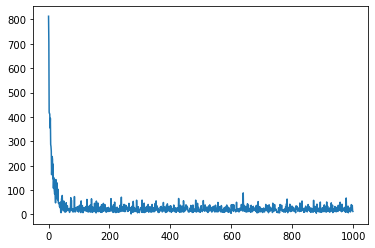

In [36]:
plt.plot(list(range(1000)), losses)

In [44]:
def predict(X: np.ndarray,
             weights: Dict[str, np.ndarray]):
    '''
    Generate predictions from step-by-step linear regression model.
    '''
    
    N = np.dot(X, weights['W'])
    
    return N + weights['B']

In [45]:
preds = predict(X_test, weights)

In [46]:
print("Mean absolute error:", round(mae(preds, y_test), 4), "\n"
      "Root mean squared error:", round(rmse(preds, y_test), 4))

Mean absolute error: 3.5644 
Root mean squared error: 5.0497


In [47]:
np.round(y_test.mean(), 4)

22.0776

In [48]:
np.round(rmse(preds, y_test) / y_test.mean(), 4)

0.2287

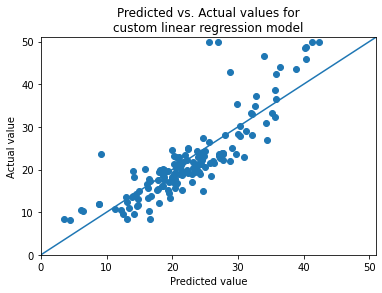

In [49]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\ncustom linear regression model")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51])

In [50]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)

test_feature = np.concatenate([a, b], axis=1)
test_preds = predict(test_feature, weights)[:, 0]

Text(0.5, 1.0, 'Most important feature vs. target and predictions,\n custom linear regression')

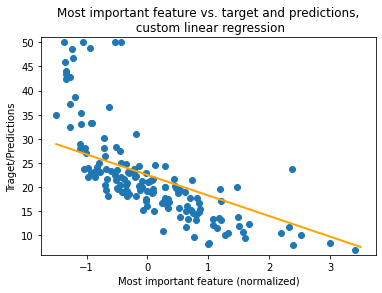

In [53]:
plt.scatter(X_test[:, 12], y_test)
plt.plot(np.array(test_feature[:, -1]), test_preds, linewidth=2, c='orange')
plt.ylim([6, 51])
plt.xlabel("Most important feature (normalized)")
plt.ylabel("Traget/Predictions")
plt.title("Most important feature vs. target and predictions,\n custom linear regression")

## Coefficients

In [54]:
np.round(weights['W'].reshape(-1), 4)

array([-1.0954,  0.7353,  0.1977,  0.7475, -2.2849,  2.2006,  0.7195,
       -2.6384,  2.5358, -1.6892, -2.3162,  0.8435, -4.2553])

In [56]:
np.round(lr.coef_, 4)

array([[-1.0148,  0.7065,  0.276 ,  0.7092, -2.206 ,  2.3793,  0.7133,
        -2.6625,  2.6325, -1.8172, -2.3266,  0.8465, -4.1889]])

In [57]:
np.round(weights['B'], 4)

array([[22.6312]])

In [58]:
np.round(lr.intercept_, 4)

array([22.6195])

## Theoretical relationship between most impoetant feature and target

In [59]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)

In [60]:
test_feature = np.concatenate([a, b], axis=1)
preds = predict(test_feature, weights)[:, 0]

(6.0, 51.0)

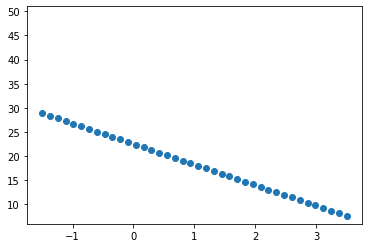

In [61]:
plt.scatter(np.array(test_feature[:, -1]), np.array(preds))
plt.ylim([6, 51])